# The Shift Calculator Script

### Import the code from the "shabat" script (this code is used only with jupyter notebook)

In [72]:
%run Import_Shabat_Data_Table.ipynb

extracting data from website: " https://calendar.2net.co.il/parasha.aspx " 
 


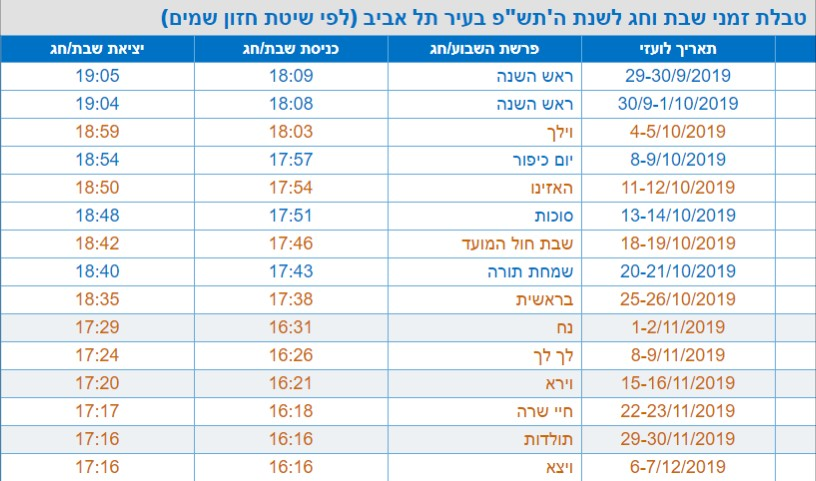

In [73]:
from IPython.display import Image
Image(filename = "Shabat table.jpeg", width = 600, height = 300)


### The imports

In [74]:
from openpyxl import load_workbook
from prettytable import PrettyTable
from tkinter import Tk
from tkinter.filedialog import askopenfile

### Extracting data from the excel file

In [75]:
def get_excel_values(sheet,dataset):
    max_row = sheet.max_row
    # get max column count
    max_column = sheet.max_column
    for i in range(1, max_row + 1):

        # iterate over all columns
        for j in range(1, max_column + 1):
            # get particular cell value
            cell_obj = sheet.cell(row=i, column=j)
            # print cell value
            dataset.append(cell_obj.value)
    return dataset

### Change the cell value into datetime type

In [76]:
def transfer_date_to_datetime(date):
    day,month,year=(int(j) for j in date.split('/'))
    date_value=datetime.date(year,month,day)
    return date_value

### Extract from the date cell the day name

In [77]:
def findDay(date):
    day, month, year = (int(i) for i in date.split('/'))
    born = datetime.date(year, month, day)
    return born.strftime("%A")

### Calculate the number of hours of work each shift

In [78]:
def calculate_work_time(entrance,exit):
    temp=exit-entrance
    if temp < datetime.timedelta(days=0):
        temp += datetime.timedelta(days=1)
    temp= round(temp.total_seconds()/60/60,2)
    
    return temp
    

### Arrange the data from the excel file into list
Using the functions that we wrote above

In [79]:
def arrange_data_into_list(dataset):
    counter=0
    temp=[]
    d=[]
    for i in dataset:
        if counter==0:
            temp.append(datetime.timedelta(hours=int(i[0:2]),minutes=int(i[3:5])))
        if counter==1:
            temp.append(datetime.timedelta(hours=int(i[0:2]),minutes=int(i[3:5])))
        if counter==2:
            temp.append(i)
        if counter==3:
            temp.append(findDay(i))
            temp.append(transfer_date_to_datetime(i))
            temp.append(calculate_work_time(temp[1],temp[0]))
            d.append(temp)
        counter+=1
        if counter==4:
            counter=0
            temp=[]

    return d

### Remove 'None' values from the excel file 

In [80]:
def remove_none_values(dataset):
    d=[]
    for i in dataset:
            if i != None:
                d.append(i)
    ##DELETING THE HEADERS
    del d[0:11]
    return d

### Date comparison function
With each date who is in saturday or friday, we check with the 'shabat data' list if the date is match.

In [81]:
def import_shabat_data(shabat,y):
    for i in shabat:
        for j in i[2]:
            if j==y:
                return i
    raise ValueError("shabat date not found")

### Shift Calculator main function 
the function gets the 'shabat' list with all the the entry and the exit times and dates, the entrance time of the shift, the exit time of the shift, the date, day name and work time.

The function pay attention if we worked in extra hours, meaning if we worked more then 8 hours we will get 125% wage, and of course the main purpose of the func  is to check if we worked in saturday or friday, if the entrance and the exit times matching the 'shabat' list times and dates, our wage increasing with 150%.

In [82]:
def shift_calculator(shabat, entrance, exit, date, day_name, worktime):
    global extra_time_counter
    global shabat_counter
    temp=0
    if day_name == 'Friday':
        x = import_shabat_data(shabat, date)
        if exit >= x[0]:
            if worktime>8:
                ##FRIDAY HALF SHABAT MORE THEN 8 HOURS
                shabat_counter+=1
                extra_hours=exit-datetime.timedelta(hours=8)
                extra_time_counter+=extra_hours.total_seconds()/60/60
                transfer=((datetime.timedelta(hours=8)+extra_hours*1.25)-x[0])*1.5
                temp+=round(transfer.total_seconds() / 60 / 60,2)
                transfer=x[0]-entrance
                temp+=round(transfer.total_seconds() / 60 / 60, 2)
            else:
                ##FRIDAY HALF SHABAT LESS THEN 8 HOURS
                shabat_counter+=1
                transfer = (exit - x[0]) * 1.5
                temp += round(transfer.total_seconds() / 60 / 60, 2)
                transfer = x[0] - entrance
                temp += round(transfer.total_seconds() / 60 / 60, 2)
        elif entrance >= x[0]:
            if worktime>8:
                ##FRIDAY SHABAT AND MORE THEN 8 HOURS
                shabat_counter += 1
                extra_hours=worktime-8
                extra_time_counter += extra_hours
                temp+=(extra_hours*1.25+8)*1.5
            else:
                ##FRIDAY SHABAT AND LESS THEN 8 HOURS
                shabat_counter += 1
                temp += worktime * 1.5
        else:
            if worktime> 8:
                extra_hours=worktime-8
                extra_time_counter += extra_hours
                temp+=extra_hours*1.25+8
            else:
                temp += worktime

    elif day_name == 'Saturday':
        x = import_shabat_data(shabat, date)
        if x[1] >= entrance:
            if worktime>8:
                ##HALF SHABAT AND MORE THEN 8 HOURS
                shabat_counter += 1
                extra_hours=exit-datetime.timedelta(hours=8)
                extra_time_counter += extra_hours.total_seconds() / 60 / 60
                transfer=(x[1]-entrance)*1.5
                temp+=round(transfer.total_seconds() / 60 / 60, 2)
                transfer=(extra_hours*1.25+datetime.timedelta(hours=8))-x[1]
                temp += round(transfer.total_seconds() / 60 / 60, 2)
            else:
                ##HALF SHABAT AND LESS THEN 8 HOURS
                shabat_counter += 1
                transfer = (x[1] - entrance) * 1.5
                temp += round(transfer.total_seconds() / 60 / 60, 2)
                transfer = exit - x[1]
                temp += round(transfer.total_seconds() / 60 / 60, 2)
        elif exit <= x[1]:
            ##IN SHABAT AND MORE THEN 8 HOURS

            if worktime>8:
                shabat_counter += 1
                extra_hours=worktime-8
                extra_time_counter += extra_hours
                temp+=(extra_hours*1.25+8)*1.5
            else:
                ##IN SHABAT AND LESS THEN 8 HOURS
                shabat_counter += 1
                temp += worktime * 1.5
        else:
            ##AFTER SHABAT AND MORE THEN 8 HOURS
            if worktime>8:
                extra_hours = worktime - 8
                extra_time_counter += extra_hours
                temp+=extra_hours*1.25+ 8
            else:
                ##AFTER SHABAT AND LESS THEN 8 HPURS
                temp += worktime
    else:
        ##REGULAR DAY AND MORE THEN 8 HOURS
        if worktime>8:
            extra_hours=worktime-8
            extra_time_counter += extra_hours
            temp+=extra_hours*1.25+8
        else:
            ##REGULAR DAY AND LESS THEN 8 HOURS
            temp+=worktime
    return temp

### Print shifts function
using PrettyTable module

In [83]:
def print_shifts(dataset):
    t=PrettyTable(['Date','Day','Entrance', 'Exit','Total Time', 'Site name'])
    print(f"Your Shifts in {dataset[0][4].strftime('%B')} were:")
    for i in dataset:
        t.add_row([i[4],i[3],i[1],i[0],i[-1],i[2]])
    print(t)

### Using Tkinter
this code we used only in the python terminal, this code asking from the user to open the excel file, because we are using jupyter notebook i just added the excel file to the current folder.
you can ignore the code below.

In [84]:
##Tk().withdraw()
##filenametk=askopenfile(mode='r',title="Please choose Excel file",filetypes =[('Excel Files', '*.xlsx')])
##workbook = load_workbook(filename=filenametk.name)


### Load the excel file
using method of the module openpyxl

In [85]:
workbook = load_workbook(filename='august shifts.xlsx')

### Create Variables

Get the currently active sheet

In [86]:
sheet = workbook.active

creating empty list for the shifts data

In [87]:
dataset=[]

variables for saving the amount of times we worked in friday/saturday and the summarize of all the time we worked in extra hours

In [88]:
shabat_counter=0
extra_time_counter=0

### Arrange and clean the data from the excel file using the functions
pay attention this script is made especially for how the excel file i using is structre,
meaning other excel file with diffrent cell arrange probally will not work.

In [89]:
dataset=get_excel_values(sheet,dataset)
dataset=remove_none_values(dataset)
dataset=arrange_data_into_list(dataset)

### Print the shifts

In [90]:
print_shifts(dataset)


Your Shifts in August were:
+------------+-----------+----------+----------+------------+---------------------+
|    Date    |    Day    | Entrance |   Exit   | Total Time |      Site name      |
+------------+-----------+----------+----------+------------+---------------------+
| 2020-08-02 |   Sunday  | 7:05:00  | 14:50:00 |    7.75    |      מרכז בקרה      |
| 2020-08-05 | Wednesday | 16:07:00 | 23:17:00 |    7.17    |      מרכז בקרה      |
| 2020-08-08 |  Saturday | 23:04:00 | 7:07:00  |    8.05    |      מרכז בקרה      |
| 2020-08-09 |   Sunday  | 22:55:00 | 7:04:00  |    8.15    |      מרכז בקרה      |
| 2020-08-11 |  Tuesday  | 16:10:00 | 21:49:00 |    5.65    |      מרכז בקרה      |
| 2020-08-13 |  Thursday | 16:30:00 | 21:14:00 |    4.73    |      מרכז בקרה      |
| 2020-08-15 |  Saturday | 23:03:00 | 7:15:00  |    8.2     |      מרכז בקרה      |
| 2020-08-17 |   Monday  | 15:59:00 | 21:02:00 |    5.05    |      מרכז בקרה      |
| 2020-08-19 | Wednesday | 23:05:00 | 7:09:00  |

### Calculate the hours using the main function

In [91]:
total_hours=0
for i in dataset:
    total_hours+=shift_calculator(shabat, i[1], i[0], i[4], i[3], i[-1])


### Get the wage per hour from the user

In [92]:
wage= int(input(f"What is your wage per Hour?" ))

What is your wage per Hour?38


### Summary of the data

In [93]:
print(f"you made this month {round(total_hours*wage,2)} shekels")
print(f"{len(dataset)} Shifts, {shabat_counter} were on 150% ")
print(f"Your total hours: {round(sum([x[-1] for x in dataset],2))}, in extra hours: {round(extra_time_counter, 2)}")
print('Great Job!')

you made this month 4316.94 shekels
14 Shifts, 3 were on 150% 
Your total hours: 103, in extra hours: 0.59
Great Job!
